## Comparison to embryo pseudobulk
Pseudobulk from *Pijuan et al 2019*

In [38]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

from custom_functions import *

save_format = "svg"

In [39]:
# select which timepoint to analyze
time='120'
#time='144'

## Load data


In [40]:
# load counts and metadata, select your path
df_gastruloid = pd.read_csv("data/cell_comp_bulk.csv",index_col=0).T
df_gastruloid = df_gastruloid.loc[:,~df_gastruloid.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)
df_gastruloid_metadata = pd.read_csv("data/metadata_cell_comp.csv",index_col=0)


#Retain only samples of interest
if time=='120':
    #if include_epis:
    df_gastruloid = df_gastruloid.loc[[(("120" in i)) for i in df_gastruloid.index.values]]
    df_gastruloid_metadata = df_gastruloid_metadata.loc[[(("120" in i)) for i in df_gastruloid_metadata.index.values]]
else:
    df_gastruloid = df_gastruloid.loc[[(("144" in i)) for i in df_gastruloid.index.values]]
    df_gastruloid_metadata = df_gastruloid_metadata.loc[[(("144" in i)) for i in df_gastruloid_metadata.index.values]]

### Load Epi SC and Epi gastruloids counts

In [41]:
# if TRUE, include epi gastruloids dataset
include_epis=True

In [42]:
if include_epis:
    epigastruloids=pd.read_csv('data/chir_act_counts.csv',index_col=0).T
    epigastruloids = epigastruloids.loc[[i for i in epigastruloids.index if 'Epi' in i or'120h-3μM-CHIR'],:]

    episc=pd.read_csv('data/epi_counts.csv',index_col=0).T
    episc = episc.loc[[i for i in episc.index if '400' in i],:]

In [43]:
if include_epis:
    # Step 1: Identify common genes
    common_genes = list(set(df_gastruloid.columns) & set(epigastruloids.columns) & set(episc.columns))

    # Step 2: Filter the dataframes to retain only the common genes
    df1_filtered = df_gastruloid[common_genes]
    df2_filtered = epigastruloids[common_genes]
    df3_filtered = episc[common_genes]

    # Step 3: Concatenate the filtered dataframes along the rows (samples)
    df_gastruloid = pd.concat([df1_filtered, df2_filtered, df3_filtered], axis=0)



## Pseudobulk mouse

From the generated pseudobulk mouse dataset, we keep all points except from one sample at E7.25, which had some sampling problems (refer to the original paper) and the mixed samples.

In [44]:
df_embryo = pd.read_csv("data/pijuansala_extended_pseudobulk.csv",index_col=0)
df_embryo = df_embryo.loc[:,~df_embryo.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)

# #Remove samples
df_embryo = df_embryo[df_embryo.index.values != "S26_E7.25"]
df_embryo = df_embryo[df_embryo.index.values != "Mixed gastrulation_21"]
df_embryo = df_embryo[df_embryo.index.values != "Mixed gastrulation_22"]
df_embryo=df_embryo.iloc[:34,:]
df_embryo.sort_index(inplace=True)

df_embryo_metadata = pd.DataFrame({"Condition":[i[:-2] for i in df_embryo.index.values]},index=df_embryo.index.values)

### Make consistent the datasets

Since both datasets can come from different alignement processes, we just retain common aligned genes.

In [45]:
genes1 = df_gastruloid.columns.values
genes2 = df_embryo.columns.values
common_genes = np.intersect1d(genes1,genes2) #Get common genes

df_gastruloid = df_gastruloid.loc[:,common_genes]
df_embryo = df_embryo.loc[:,common_genes]

# Analysis

## Scaling

We scale the data normalizing the sum of total counts and producing and scaling to log1p.

In [46]:
df1 = df_gastruloid.copy()
df1 = df1.div(df1.sum(axis=1), axis=0)*10E6
df1 = np.log1p(df1)
df1.fillna(0,inplace=True)

df2 = df_embryo.copy()
df2 = df2.div(df2.sum(axis=1), axis=0)*10E6
df2 = np.log1p(df2)
df2.fillna(0,inplace=True)

## Feature selection

We select the most varying genes of both datasets and find the common number between both datasets. We use a simple variance threshold to choose the most varying genes.

Free parameters: **threshold**

In [47]:
fs = VarianceThreshold(threshold=8)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

len(l)

5

In [48]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index)
df2_fs = pd.DataFrame(fs.transform(df2.values),index=df2.index)

## Distance Matrix

We show the correlation between CHIRON conditions (C is 48h control) and Pijuan-Sala, showing the progression.

In [49]:
df1_fs=df1_fs.loc[[i for i in df1_fs.index if 'cells' not in i or 'Epi' not in i],:]

In [50]:
d_euclidean,m_euclidean = distance_table(df1_fs,df2_fs,metric="euclidean")

## Averaged distance matrix

The same but averaged over conditions.

In [ ]:
# Order to plot the bulk conditions
# if time=='E8.5':
#     order = ['0h-Epi_','KK120','KF120','WF120','WW120','120h-3μM-CHIR_']
# else:
#     order = ['0h-Epi_','KK144','KF144','WF144','WW144','120h-3μM-CHIR_']

if time=='120':
    order = ['KK120','KF120','WF120','WW120']
else:
    order = ['KK144','KF144','WF144','WW144']


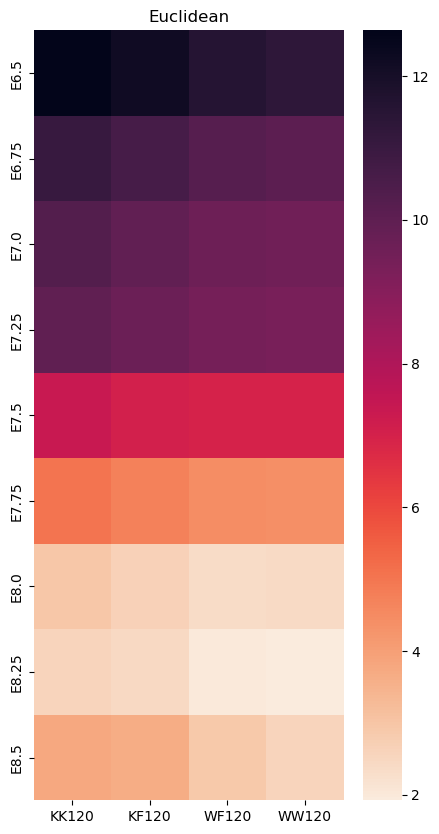

In [52]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
d_euclidean_ = d_euclidean.groupby([i[:-1] for i in d_euclidean.index.values]).mean()
d_euclidean_ = d_euclidean_.T.groupby([i.split("_")[0] for i in d_euclidean_.columns.values]).mean().T
sns.heatmap(d_euclidean_.loc[order,:].transpose(), cmap="rocket_r", ax=ax)
ax.set_title("Euclidean");

plt.savefig(f"results/figures/cell_comp_embryo_mean_{time}.{save_format}",bbox_inches="tight",transparent=True)

## Correlating with embryo time per population

In [53]:
df_gastruloid = pd.read_csv("data/cell_comp_bulk.csv",index_col=0).T
df_gastruloid = df_gastruloid.loc[:,~df_gastruloid.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)
df_gastruloid_metadata = pd.read_csv("data/metadata_cell_comp.csv",index_col=0)

epigastruloids=pd.read_csv('data/chir_act_counts.csv',index_col=0).T
epigastruloids = epigastruloids.loc[[i for i in epigastruloids.index if 'Epi' in i or '120h-3μM-CHIR' in i],:]

# Step 1: Identify common genes
common_genes = list(set(df_gastruloid.columns) & set(epigastruloids.columns))

# Step 2: Filter the dataframes to retain only the common genes
df1_filtered = df_gastruloid[common_genes]
df2_filtered = epigastruloids[common_genes]

# Step 3: Concatenate the filtered dataframes along the rows (samples)
df_gastruloid = pd.concat([df1_filtered, df2_filtered], axis=0)

## Consistent datasets

In [54]:
genes1 = df_gastruloid.columns.values
genes2 = df_embryo.columns.values
common_genes = np.intersect1d(genes1,genes2) #Get common genes

df_gastruloid = df_gastruloid.loc[:,common_genes]
df_embryo = df_embryo.loc[:,common_genes]

## Analysis

In [55]:
df1 = df_gastruloid.copy()
df1 = df1.div(df1.sum(axis=1), axis=0)*10E6
df1 = np.log1p(df1)
df1.fillna(0,inplace=True)

df2 = df_embryo.copy()
df2 = df2.div(df2.sum(axis=1), axis=0)*10E6
df2 = np.log1p(df2)
df2.fillna(0,inplace=True)

In [56]:
fs = VarianceThreshold(threshold=1)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

len(l)

928

In [57]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index)
df2_fs = pd.DataFrame(fs.transform(df2.values),index=df2.index)

## PCA

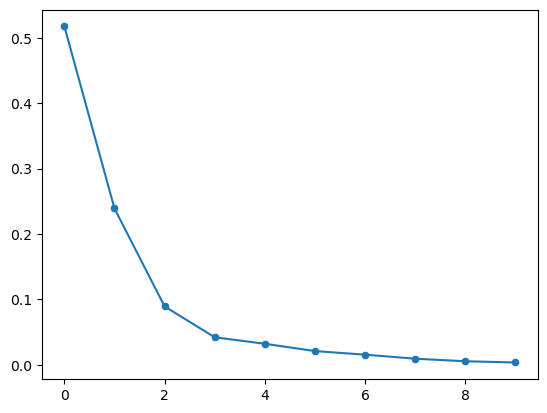

In [58]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=df1.columns.values[l])
pca = PCA(n_components=10)
pca.fit(df1_fs.values)

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)

# save plot
plt.savefig(f'results/figures/explained_variance_by_pca_epis.{save_format}')

In [59]:
names = df1.columns.values[[int(i[1:]) for i in fs.get_feature_names_out()]] # get gene names for most variant
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=names)
pca = PCA(n_components=min(df1.shape[0]-1,10))
pca.fit(fs.transform(df1.values));

# pca transform
x = pca.transform(fs.transform(df1.values))

Text(0, 0.5, 'PC2: 24% variance')

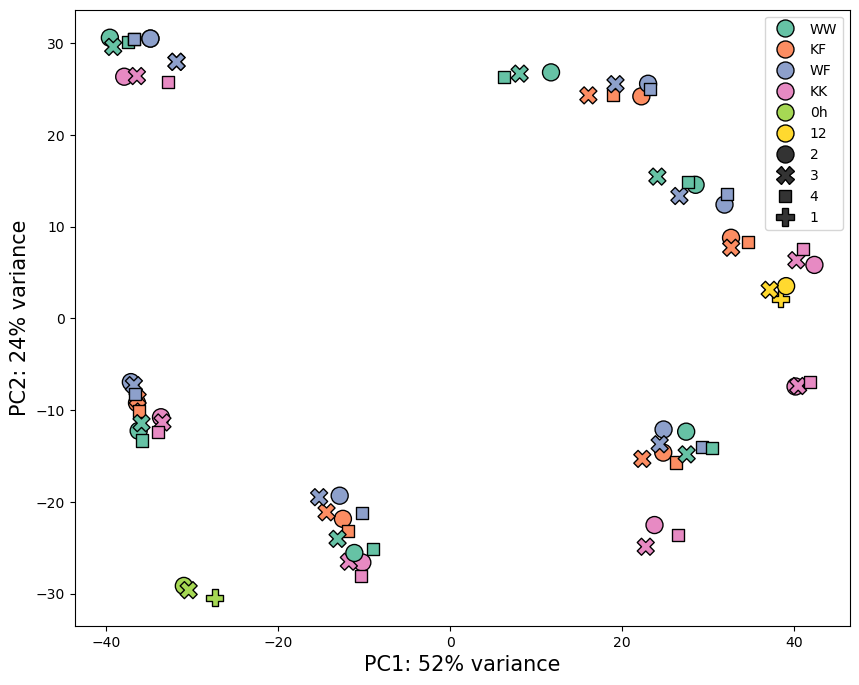

In [60]:
fig,ax=plt.subplots(1,figsize=(10,8))
sns.scatterplot(x=x[:,0], y=x[:,1], s=150, edgecolor='black',hue=[b[:2] for b in df1.index], palette='Set2', style=[b[-1] for b in df1.index])
#sns.scatterplot(x=x[:,0], y=x[:,1], s=150, edgecolor='black',hue=meta['Time'], ax=ax[1], palette='Set2', style=[b[-1] for b in df_.index])

# axes
ax.set_xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=15)
ax.set_ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=15)

# ax[1].set_xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=15)
# ax[1].set_ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=15)


#plt.savefig(f"results/figures/pca_scatterplot_clone_time_epis.{save_format}",bbox_inches="tight",transparent=True)

### Distance matrix

In [61]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index)
df2_fs = pd.DataFrame(fs.transform(df2.values),index=df2.index)

In [62]:
populations = ['WW','WF','KF','KK']

for p in populations:
    df1_fs_ = df1_fs.loc[[i for i in df1_fs.index if p in i],:]
    df1_fs_ = df1_fs.loc[[i for i in df1_fs.index if p in i or 'Epi'],:]
    d_euclidean,m_euclidean = distance_table(df1_fs_,df2_fs,metric="euclidean")

    order = [f'{p}000', f'{p}048', f'{p}072', f'{p}096', f'{p}120']
    order = [
        '0h-Epi_', f'{p}000', f'{p}048', f'{p}072', f'{p}096', f'{p}120', f'{p}144'
    ]

    fig, ax = plt.subplots(1,1,figsize=(5,10))
    d_euclidean_ = d_euclidean.groupby([i[:-1] for i in d_euclidean.index.values]).mean()
    d_euclidean_ = d_euclidean_.T.groupby([i.split("_")[0] for i in d_euclidean_.columns.values]).mean().T
    d_euclidean_ = d_euclidean_.loc[order,:]
    sns.heatmap(d_euclidean_.transpose(), cmap="rocket_r", ax=ax)
    ax.set_title(f"Heatmap for {p}")
    plt.tight_layout()
    plt.savefig(f"results/figures/embryo_correlation_{p}_epis.{save_format}",bbox_inches="tight",transparent=True)
    plt.close()


In [63]:
d_euclidean,m_euclidean = distance_table(df1_fs,df2_fs,metric="euclidean")

## Pseudobulk sections

In [64]:
df_embryo = pd.read_csv("data/pseudobulk_sections.csv", index_col=0)
df_embryo = df_embryo.loc[:,~df_embryo.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)

# select timepoint
time='E8.75'
df_embryo=df_embryo[df_embryo.Stage.isin([time])]
df_embryo

,Stage,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,PISD,DHRSX,Vmn2r122,CAAA01147332.1
Anatomy,,,,,,,,,,,,,,,,,,,,,
Anterior section,E8.75,31.0,1.0,0.0,9.0,547.0,0.0,19127.0,3090.0,11.0,...,0.0,0.0,0.0,0.0,0.0,3.0,1195.0,2395.0,0.0,63.0
Medial section,E8.75,16.0,1.0,0.0,11.0,806.0,3.0,19859.0,3352.0,13.0,...,0.0,0.0,0.0,0.0,0.0,3.0,1636.0,2909.0,0.0,91.0
Posterior section,E8.75,4.0,0.0,0.0,0.0,494.0,0.0,9508.0,1350.0,4.0,...,0.0,0.0,0.0,0.0,0.0,3.0,745.0,1456.0,0.0,46.0


In [65]:
# consistent datasets
genes1 = df_gastruloid.columns.values
genes2 = df_embryo.columns.values
common_genes = np.intersect1d(genes1,genes2) #Get common genes

df_gastruloid = df_gastruloid.loc[:,common_genes]
df_embryo = df_embryo.loc[:,common_genes]

### Scaling 

In [66]:
df1 = df_gastruloid.copy()
df1 = df1.div(df1.sum(axis=1), axis=0)*10E6
df1 = np.log1p(df1)
df1.fillna(0,inplace=True)

df2 = df_embryo.copy()
df2 = df2.div(df2.sum(axis=1), axis=0)*10E6
df2 = np.log1p(df2)
df2.fillna(0,inplace=True)

### Feature selection

In [67]:
fs = VarianceThreshold(threshold=1)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

len(l)

928

In [68]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index)
df2_fs = pd.DataFrame(fs.transform(df2.values),index=df2.index)

## Distance matrix

In [69]:
d_euclidean,m_euclidean = distance_table(df1_fs,df2_fs,metric="euclidean")

## Mean distance matrix

In [ ]:
# if time=='E8.5':
#     order = ['0h-Epi_','KK120','KF120','WF120','WW120','120h-3μM-CHIR_']
# else:
#     order = ['0h-Epi_','KK144','KF144','WF144','WW144','120h-3μM-CHIR_']

if time=='E8.5':
    order = ['0h-Epi_','KK120','KF120','WF120','WW120']
else:
    order = ['0h-Epi_','KK144','KF144','WF144','WW144']


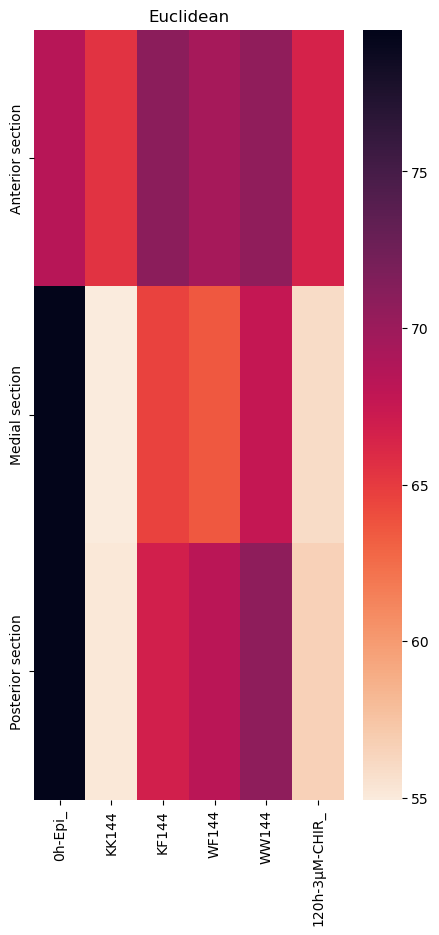

In [71]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
d_euclidean_ = d_euclidean.groupby([i[:-1] for i in d_euclidean.index.values]).mean()
d_euclidean_ = d_euclidean_.T.groupby([d_euclidean_.columns.values]).mean().T
d_euclidean_=d_euclidean_.loc[[i for i in d_euclidean_.index if 'cells' not in i],:]
sns.heatmap(d_euclidean_.loc[order,:].transpose(), cmap="rocket_r", ax=ax)
ax.set_title("Euclidean");

plt.savefig(f"results/figures/chir_conditions_analysis_heatmap_sections_{time}.{save_format}",bbox_inches="tight",transparent=True)